<a href="https://colab.research.google.com/github/saifulislamsarfaraz/unsupervised-autoencoder-som-clustering/blob/main/single_cell_Autoencoder_and_SOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install minisom scanpy tensorflow matplotlib seaborn igraph leidenalg louvain


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00


In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from minisom import MiniSom
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

Preprocessed dataset: 2700 cells, 2000 genes


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


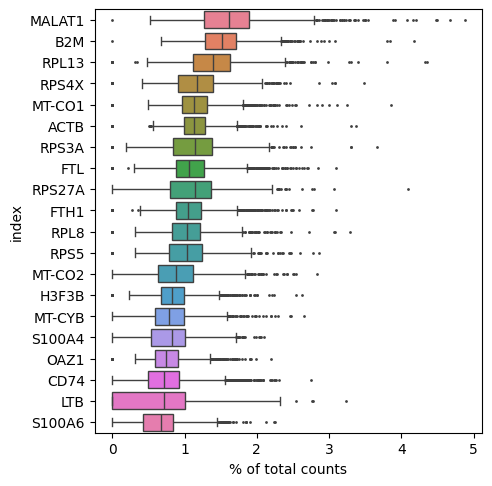

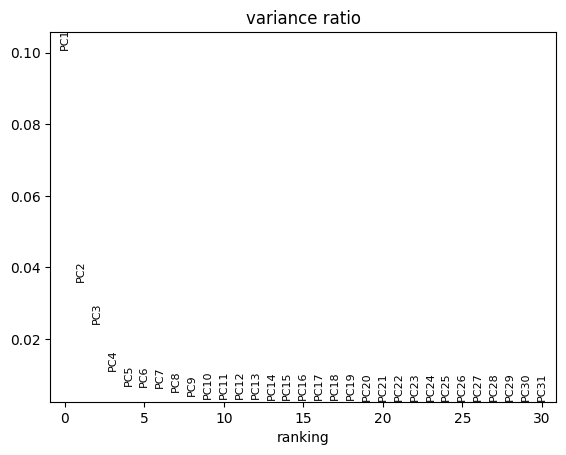

In [ ]:
# Load and preprocess data
adata = sc.datasets.pbmc3k()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]

print(f"Preprocessed dataset: {adata.shape[0]} cells, {adata.shape[1]} genes")

# Exploratory analysis
sc.pl.highest_expr_genes(adata, n_top=20, save='_top_genes.png')
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, save='_pca_variance.png')

# Scale data
X = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X
X = StandardScaler().fit_transform(X)

In [ ]:
# Build Autoencoder
input_dim = X.shape[1]
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
encoded = Dense(encoding_dim)(x)  # No ReLU for SOM
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-5))(encoded)
decoded = Dense(input_dim, activation='linear', kernel_regularizer=l2(1e-5))(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.summary()

# Parameter counting
print(f"Total trainable parameters: {autoencoder.count_params()}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2000)           │     1,026,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,118,672 (8.08 MB)

 Trainable params: 2,117,648 (8.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

Total trainable parameters: 2118672


In [ ]:
# Train Autoencoder
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X, X,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training/validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss.png')
plt.close()

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.0764 - val_loss: 0.9877
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.9626 - val_loss: 0.9734
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.9487 - val_loss: 0.9706
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.9443 - val_loss: 0.9651
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.9110 - val_loss: 0.9648
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.8901 - val_loss: 0.9635
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.8973 - val_loss: 0.9645
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.8581 - val_loss: 0.9658
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.8502 - val_loss: 0.9648
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.8479 - val_loss: 0.9699
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.8352 - val_loss: 0.9678
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.8

In [ ]:
# Encode data
latent_X = encoder.predict(X, batch_size=32)
adata.obsm['X_latent'] = latent_X
print(f"Latent space shape: {latent_X.shape}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Latent space shape: (2700, 64)


In [ ]:
# SOM clustering with hyperparameter tuning
som_size = 4  # 4x4 grid (16 clusters)
encoding_dim = latent_X.shape[1]

# Tune SOM hyperparameters (sigma, learning_rate)
best_score = -1
best_params = None
for sigma in [0.5, 1.0, 1.5]:
    for lr in [0.3, 0.5, 0.7]:
        som = MiniSom(som_size, som_size, encoding_dim, sigma=sigma, learning_rate=lr)
        som.random_weights_init(latent_X)
        som.train_random(latent_X, 1000, verbose=False)
        win_map = np.array([som.winner(x) for x in latent_X])
        cluster_ids = [i * som_size + j for i, j in win_map]
        score = silhouette_score(latent_X, cluster_ids)
        print(f"SOM: sigma={sigma}, lr={lr}, Silhouette={score:.3f}")
        if score > best_score:
            best_score = score
            best_params = (sigma, lr)

# Retrain with best parameters
som = MiniSom(som_size, som_size, encoding_dim, sigma=best_params[0], learning_rate=best_params[1])
som.random_weights_init(latent_X)
som.train_random(latent_X, 1000, verbose=True)
win_map = np.array([som.winner(x) for x in latent_X])
clusters = [f"{i}-{j}" for i, j in win_map]
cluster_ids = [i * som_size + j for i, j in win_map]
adata.obs['som_cluster'] = clusters
adata.obs['som_cluster_id'] = cluster_ids

SOM: sigma=0.5, lr=0.3, Silhouette=0.010
SOM: sigma=0.5, lr=0.5, Silhouette=0.022
SOM: sigma=0.5, lr=0.7, Silhouette=0.024
SOM: sigma=1.0, lr=0.3, Silhouette=-0.003
SOM: sigma=1.0, lr=0.5, Silhouette=-0.003
SOM: sigma=1.0, lr=0.7, Silhouette=0.005
SOM: sigma=1.5, lr=0.3, Silhouette=-0.010
SOM: sigma=1.5, lr=0.5, Silhouette=-0.010
SOM: sigma=1.5, lr=0.7, Silhouette=0.002
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 13.78516527684655


In [ ]:
# KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(latent_X).astype(str)
kmeans_score = silhouette_score(latent_X, adata.obs['kmeans'])

# PCA + Leiden
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=15)
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_pca')
leiden_score = silhouette_score(adata.obsm['X_pca'], adata.obs['leiden_pca'])

# Louvain
sc.tl.louvain(adata, resolution=0.5, key_added='louvain')
louvain_score = silhouette_score(adata.obsm['X_pca'], adata.obs['louvain'])

# SOM
som_score = silhouette_score(latent_X, adata.obs['som_cluster_id'])

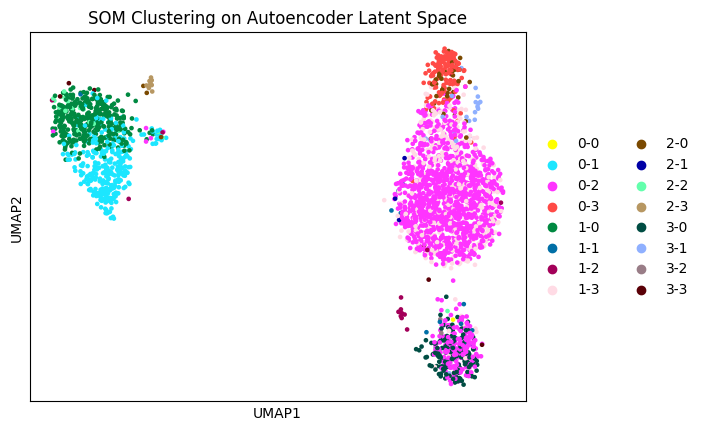

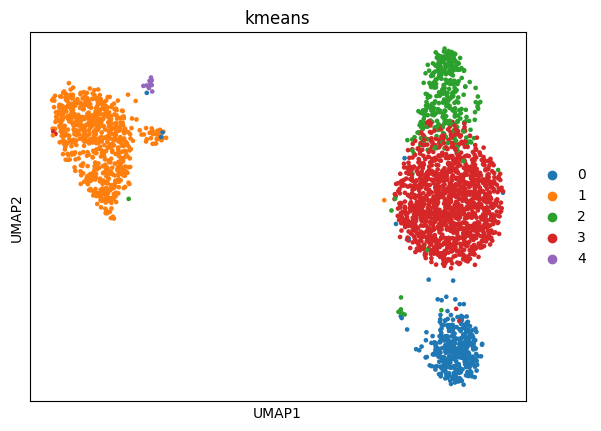

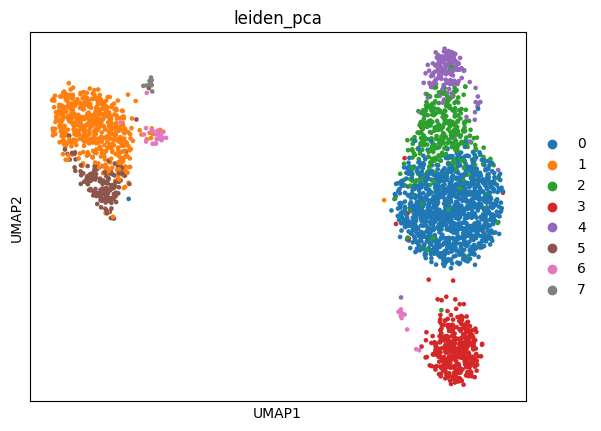

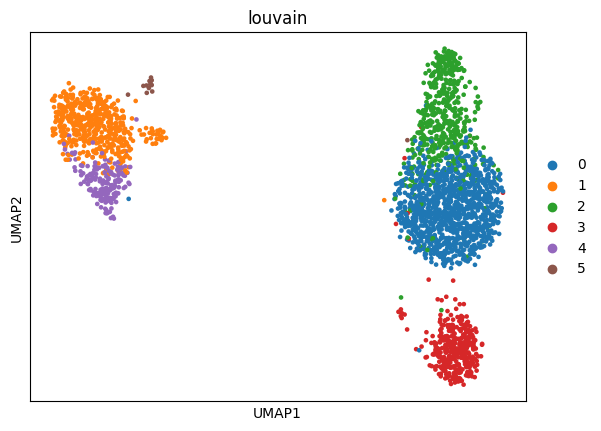

In [ ]:
# Generate UMAP plots
sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['som_cluster'], title="SOM Clustering on Autoencoder Latent Space", save='_som_umap.png')
sc.pl.umap(adata, color=['kmeans'], save='_kmeans_umap.png')
sc.pl.umap(adata, color=['leiden_pca'], save='_pca_leiden_umap.png')
sc.pl.umap(adata, color=['louvain'], save='_louvain_umap.png')